# Decoding the belief state from a value RNN

In [1]:
import numpy as np; np.set_printoptions(linewidth=150)
import torch; torch.set_printoptions(linewidth=150)
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from environment import CliffWalk
from episodes import Episode, collect_episodes, monte_carlo_state_values, episodes_to_batch, episodes_to_masks, extract_monte_carlo_returns, beliefs_to_batch
from belief_decoders import BeliefDecoder, linearBeliefDecoder, train_belief_decoder, plot_decoded_belief

In [ ]:
# TD loss function
def td_loss(values, rewards, mask_traj, lengths, gamma=1.0):
    
    # calculate the TD target
    values_next = torch.zeros_like(values)
    values_next[:, :-1] = values[:, 1:]
    for b, l in enumerate(lengths): # TD target at last value should only be the reward
        values_next[b, l-1] = 0.0
    td_target = rewards + (gamma * values_next.detach())
    
    # Calculate the TD error
    td_error = ((values - td_target) ** 2) * mask_traj
    loss = td_error.sum() / mask_traj.sum()  # average loss over non-masked values
    
    return loss


def mc_loss(values, returns, mask_monte_carlo):
    # Compute the mc loss only at start and terminal states
    mc_values = values * mask_monte_carlo
    mc_returns = returns * mask_monte_carlo
    
    # Set first state return to the average of all first states
    start_state_return = mc_returns[:, 0].mean()
    mc_returns[:, 0] = start_state_return  

    mc_error = (mc_values - mc_returns) ** 2

    mc_loss = mc_error.sum() / mask_monte_carlo.sum()  # average loss over non-masked values

    return mc_loss

def evaluate_episode(model, episode):
    model.eval()  # switch to eval mode

    with torch.no_grad():
        history = torch.tensor(episode.history, dtype=torch.float32).unsqueeze(0)  # shape: [1, T, D]
        length = [history.shape[1]]  # length = [T]
        mask = torch.ones((1, history.shape[1]), dtype=torch.float32)

        predicted_values, _ = model(history, mask)  # shape: [1, T]
        return predicted_values.squeeze(0).numpy()  # shape: [T]
    
def validate(model, test_episode, value):
    true_values = test_episode.belief_states @ value
    true_values = np.round(true_values, 2)
    
    values = evaluate_episode(model, test_episode)
    values = np.round(values, 2)

    print("True Values:")
    print(true_values)
    print("Predicted Values:")
    print(values)
    plt.figure(figsize=(10, 5))
    plt.plot(true_values, label='True Values', marker='o')
    plt.plot(values, label='Predicted Values', marker='x')
    plt.title("True vs Predicted Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()






In [4]:
# Define the RNN-based value estimator
class ValueRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        # RNN to process the history of observations and actions
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        
        # Head to output the value for each time step from the RNN output
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x, mask):
        hidden_states, _ = self.rnn(x)  # [B, T, H]
        
        # Calculate the output values for each time step
        values = self.head(hidden_states)  # [B, T, 1]
        values = values.squeeze(-1)  # [B, T]
        values = values * mask  # Apply the mask to the output

        return values, hidden_states
    
# Training loop
def train(model, episodes, test_episode, value=None, num_epochs=10, gamma=1.0, lr=1e-3, validate_every=500, batch_size=32):
    
    histories, rewards = episodes_to_batch(episodes)
    mask, mask_monte_carlo, lengths = episodes_to_masks(episodes)
    mc_returns = extract_monte_carlo_returns(rewards, mask, gamma)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    
    model.train()

    for epoch in range(num_epochs):
        # Validate sometimes
        if (epoch) % validate_every == 0:
            validate(model, test_episode, value)

        # choose "batch_size" random episodes from the dataset
        indices = np.random.choice(len(episodes), size=min(batch_size, len(episodes)), replace=False)
        batch_lengths = [lengths[i] for i in indices]

        # Calculate the estimated values
        optimizer.zero_grad()
        values, _ = model(histories[indices], mask[indices])  # shape: [B, T]
        
        # Calculate losses, and combine them
        td_L = td_loss(values, rewards[indices], mask[indices], batch_lengths, gamma)
        mc_L = mc_loss(values, mc_returns[indices], mask_monte_carlo[indices])
        loss = td_L + mc_L 
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print losses
        print(f"Epoch {epoch+1}, TD Loss: {np.sqrt(td_L.item()):.4f}, MC Loss: {np.sqrt(mc_L.item()):.4f}, Total: {np.sqrt(loss.item()):.4f}     ", end= '\r')
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, TD Loss: {np.sqrt(td_L.item()):.4f}, MC Loss: {np.sqrt(mc_L.item()):.4f}, Total: {np.sqrt(loss.item()):.4f}")
        

## Collect Data

Empirical Value function:
[[-12.07 -10.32  -8.21  -5.04]
 [-11.05  -9.3   -7.23  -2.83]
 [-12.16 -10.   -10.     0.  ]]


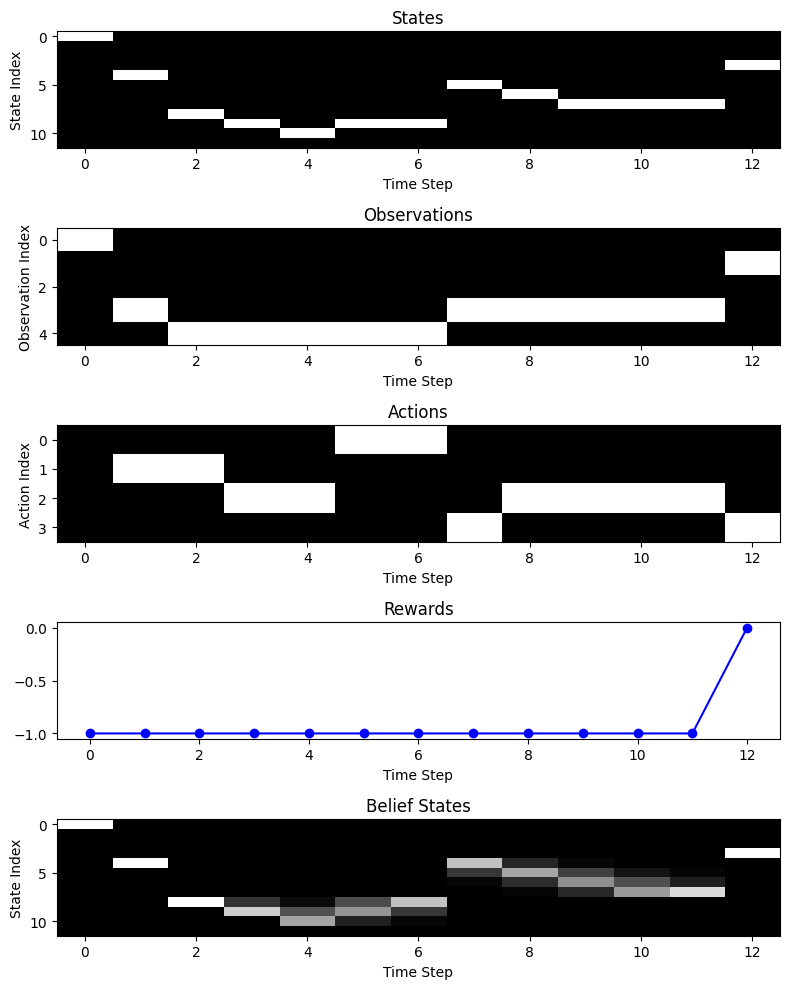

In [5]:
cliff = CliffWalk(n=3, m=4, self_transition_prob=0.2, gamma=1.0)
policy = cliff.get_optimal_policy(epsilon=0.3)

episodes = collect_episodes(cliff, policy, num_episodes=50000)
history_dim = episodes[0].history.shape[1]  # Number of features in the history (observations + actions)

print("Empirical Value function:")
value_empirical = monte_carlo_state_values(episodes, gamma=cliff.gamma)
print(np.flip(value_empirical.reshape((cliff.n, cliff.m)), axis=0))

test_episode = collect_episodes(cliff, policy, num_episodes=1)[0]
#test_episode = episodes[0]
test_episode.render()

## Train Model

True Values:
[-12.16 -11.05 -12.07 -10.67  -9.04 -10.57 -11.59 -10.57  -9.06  -7.14  -4.73  -3.5    0.  ]
Predicted Values:
[0.09 0.09 0.09 0.08 0.07 0.06 0.05 0.07 0.07 0.07 0.07 0.07 0.08]


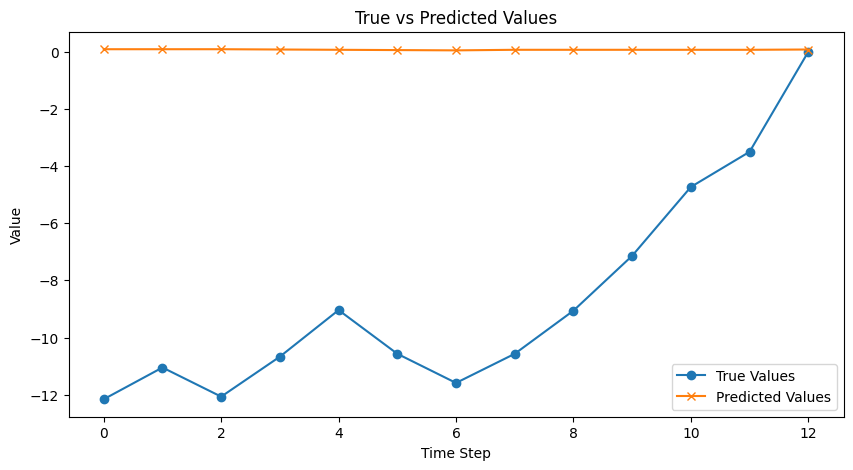

Epoch 50, TD Loss: 2.4743, MC Loss: 8.5287, Total: 8.8804      
Epoch 100, TD Loss: 3.6790, MC Loss: 2.4060, Total: 4.3959     
Epoch 150, TD Loss: 2.4219, MC Loss: 0.3587, Total: 2.4483     
Epoch 200, TD Loss: 2.1792, MC Loss: 0.2512, Total: 2.1936     
Epoch 250, TD Loss: 1.9817, MC Loss: 0.3335, Total: 2.0095     
Epoch 300, TD Loss: 1.8390, MC Loss: 0.3301, Total: 1.8684     
Epoch 350, TD Loss: 1.7869, MC Loss: 0.3194, Total: 1.8152     
Epoch 400, TD Loss: 1.7343, MC Loss: 0.2881, Total: 1.7580     
Epoch 450, TD Loss: 1.6905, MC Loss: 0.2499, Total: 1.7089     
Epoch 500, TD Loss: 1.6789, MC Loss: 0.2103, Total: 1.6921     
True Values:
[-12.16 -11.05 -12.07 -10.67  -9.04 -10.57 -11.59 -10.57  -9.06  -7.14  -4.73  -3.5    0.  ]
Predicted Values:
[-12.16 -10.8  -11.52 -10.2   -8.91  -9.58  -9.97  -7.54  -6.27  -4.98  -4.09  -3.57   0.48]


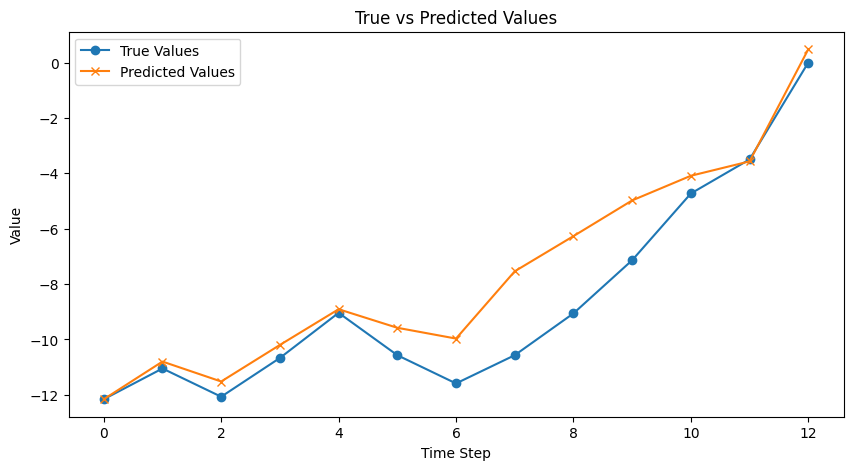

Epoch 550, TD Loss: 1.6513, MC Loss: 0.2459, Total: 1.6695     
Epoch 600, TD Loss: 1.6388, MC Loss: 0.1790, Total: 1.6486     
Epoch 650, TD Loss: 1.6472, MC Loss: 0.1450, Total: 1.6536     
Epoch 700, TD Loss: 1.6461, MC Loss: 0.1532, Total: 1.6532     
Epoch 750, TD Loss: 1.6338, MC Loss: 0.1400, Total: 1.6398     
Epoch 800, TD Loss: 1.6182, MC Loss: 0.1653, Total: 1.6266     
Epoch 850, TD Loss: 1.6251, MC Loss: 0.1393, Total: 1.6310     
Epoch 900, TD Loss: 1.6236, MC Loss: 0.1781, Total: 1.6333     
Epoch 950, TD Loss: 1.6391, MC Loss: 0.1733, Total: 1.6482     
Epoch 1000, TD Loss: 1.6263, MC Loss: 0.1076, Total: 1.6298     
True Values:
[-12.16 -11.05 -12.07 -10.67  -9.04 -10.57 -11.59 -10.57  -9.06  -7.14  -4.73  -3.5    0.  ]
Predicted Values:
[-12.07 -10.62 -11.12 -10.14  -9.02 -10.1  -10.64  -8.79  -7.63  -5.84  -4.03  -2.67   0.09]


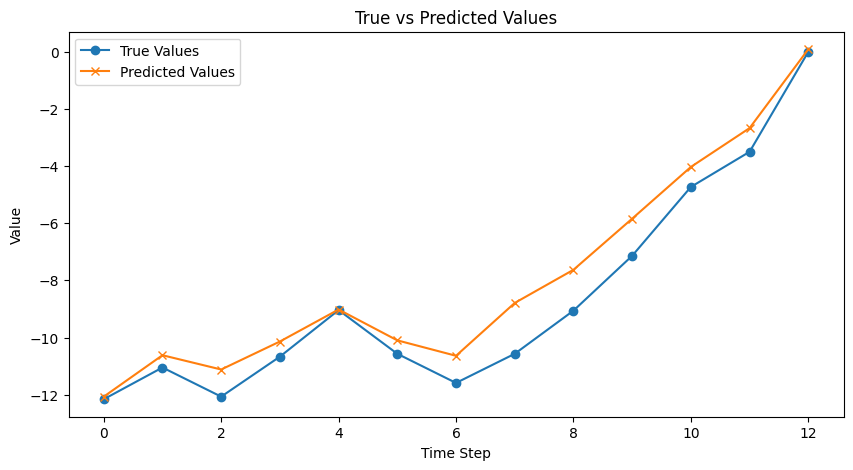

In [6]:
value_RNN = ValueRNN(input_dim=history_dim, hidden_dim=64)

train(value_RNN, episodes, test_episode, value_empirical, num_epochs=1001, gamma=1.0, lr=1e-3, validate_every=500, batch_size=2500)

## Decode Belief State

In [7]:
def estimate_entropy(belief_states, base=np.e):
    eps = 1e-12  # prevent log(0)
    belief_states = np.clip(belief_states, eps, 1.0)
    log_fn = np.log if base == np.e else lambda x: np.log2(x) if base == 2 else lambda x: np.log(x) / np.log(base)
    
    entropies = -np.sum(belief_states * log_fn(belief_states), axis=1)
    return np.round(np.mean(entropies),4)

all_belief_states = []
for episode in episodes:
    all_belief_states.append(np.array(episode.belief_states))
all_belief_states = np.concatenate(all_belief_states, axis=0)
average_entropy = estimate_entropy(all_belief_states, base=np.e)

print("Average Entropy of Belief States:", average_entropy)

Average Entropy of Belief States: 0.4236


Estimated KL Divergence Loss: 0.0231467
Validating Belief Decoder:


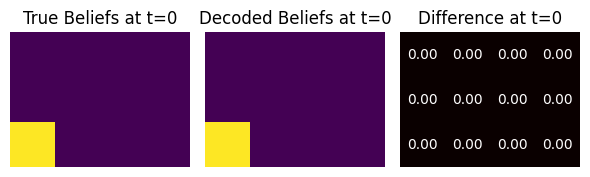

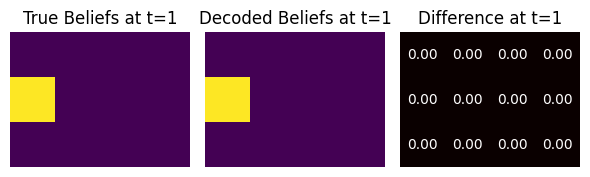

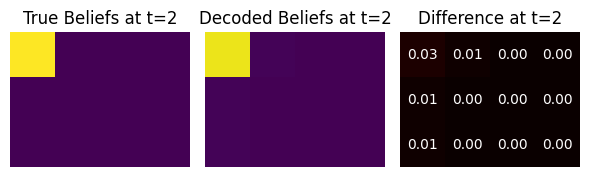

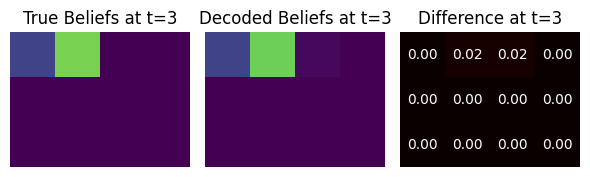

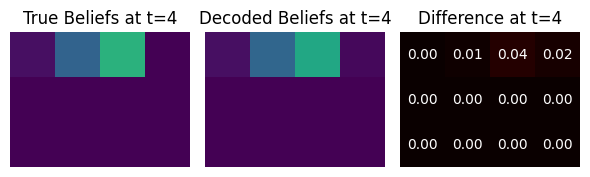

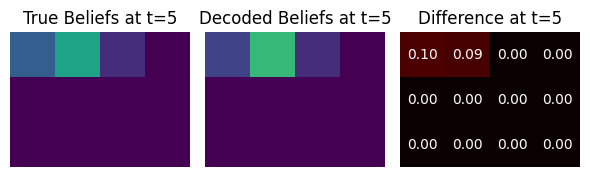

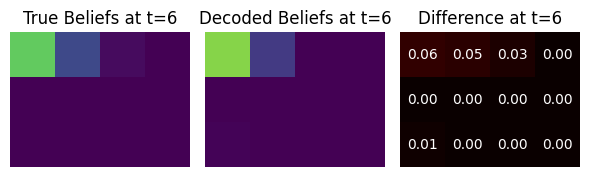

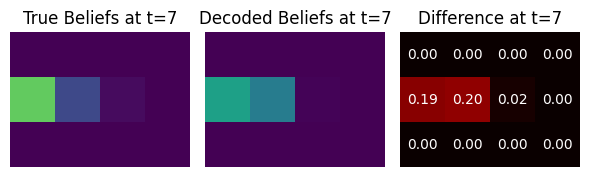

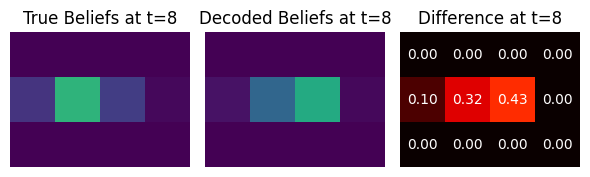

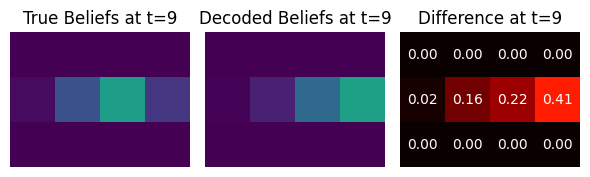

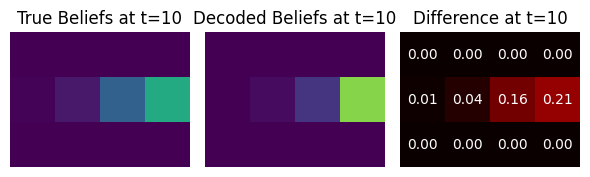

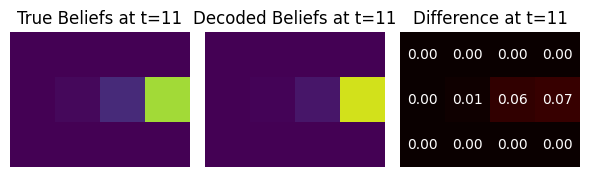

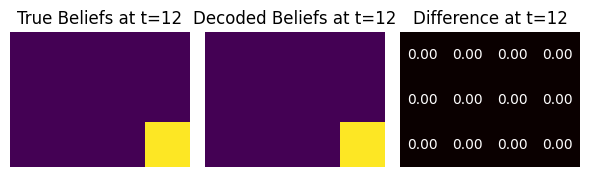

In [8]:
belief_decoder = BeliefDecoder(input_dim=64, hidden_dim=64, belief_dim=cliff.n * cliff.m)
loss = train_belief_decoder(belief_decoder, value_RNN, episodes, num_epochs=1001, lr=1e-3, batch_size=2500)
print("Estimated KL Divergence Loss:", np.round(loss - average_entropy, 4))

print("Validating Belief Decoder:")
plot_decoded_belief(value_RNN, belief_decoder, test_episode)

Estimated KL Divergence Loss: 0.4153389
Validating Linear Belief Decoder:


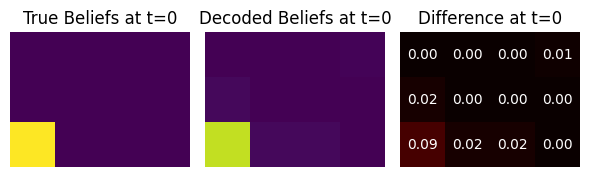

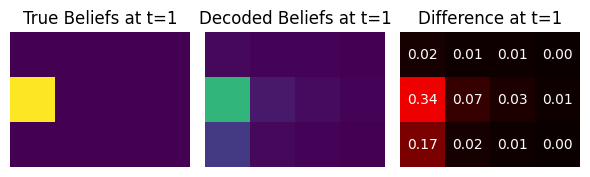

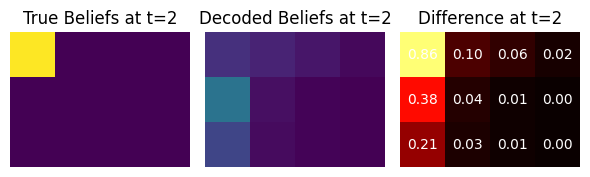

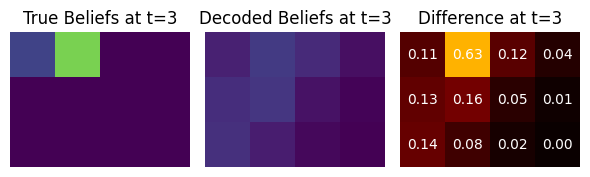

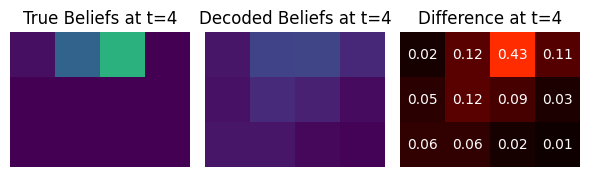

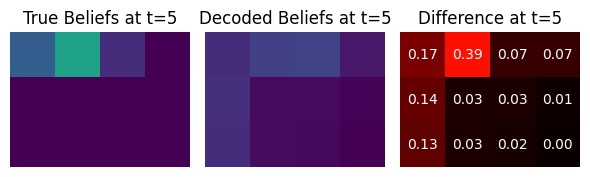

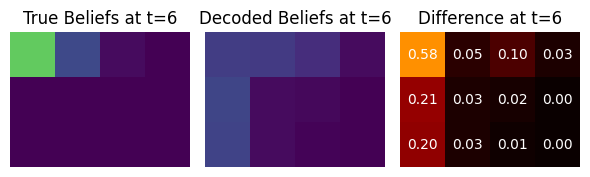

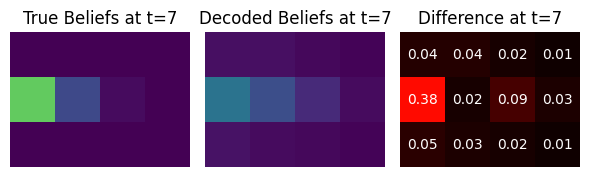

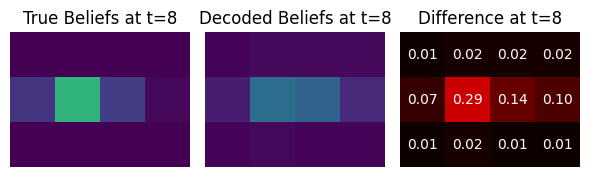

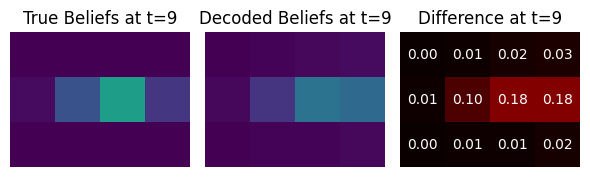

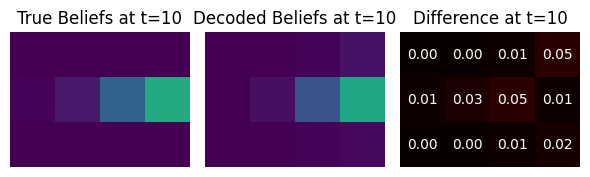

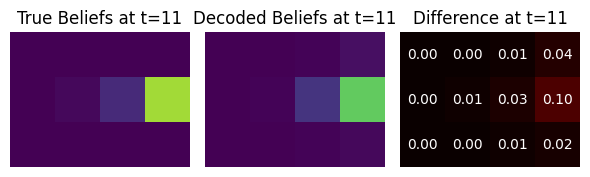

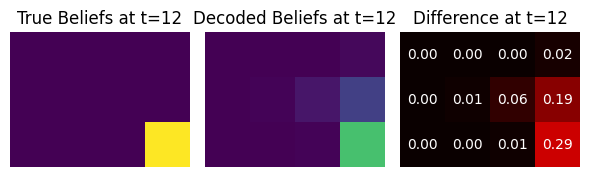

In [9]:
linear_belief_decoder = linearBeliefDecoder(input_dim=64, belief_dim=cliff.n * cliff.m)
loss =train_belief_decoder(linear_belief_decoder, value_RNN, episodes, num_epochs=1001, lr=1e-3, batch_size=2500)
print("Estimated KL Divergence Loss:", np.round(loss - average_entropy, 4))

print("Validating Linear Belief Decoder:")
plot_decoded_belief(value_RNN, linear_belief_decoder, test_episode)